In [2]:
import os
import bleach
from importlib_metadata import version
import numpy as np
from numpy.core.fromnumeric import repeat
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import tifffile as tf
import matplotlib.animation as animation
from scipy.optimize import curve_fit, fsolve
from sklearn.metrics import r2_score
import time
import csv
import json
from datetime import datetime
from IPython.display import clear_output

In [3]:
class experiment():


    def __init__(self, lsm_path, background_path, reference_path, activated_region_path, adjacent_region_path, export_path, batch_mode=True):
        self.p_lsm_file = lsm_path
        self.p_bckgrnd = background_path
        self.p_ref = reference_path
        self.p_act_granule = activated_region_path
        self.p_other_gran = adjacent_region_path[0]
        self.p_xprt = export_path
        self.batch_mode = batch_mode
        self.fps_export = 24
        self.dict_json = {
            'sample' : lsm_path,
            'csv-paths' : {'lsm':lsm_path, 'activated-region':activated_region_path, 'reference':reference_path, 'background':background_path, 'adjacent': adjacent_region_path,'export': export_path},
            'log' : []
        }


        try:
            self.tfig_path = self.p_xprt +  os.path.sep + 'figs' + os.path.sep + 'transparant' + os.path.sep
            os.makedirs(self.tfig_path) 
            self.fig_path = self.p_xprt +  os.path.sep + 'figs' + os.path.sep + 'wBackground' + os.path.sep
            os.makedirs(self.fig_path)
            self.excsv_path = self.p_xprt +  os.path.sep + 'csv' + os.path.sep
            os.makedirs(self.excsv_path)  
        except:
            time.sleep(0.005)
            self.tfig_path = self.p_xprt +  os.path.sep + 'figs' + os.path.sep + 'transparant' + os.path.sep
            self.fig_path = self.p_xprt +  os.path.sep + 'figs' + os.path.sep + 'wBackground' + os.path.sep
            self.excsv_path = self.p_xprt +  os.path.sep + 'csv' + os.path.sep
        
    def json_update(self, key, value):
        if key.lower() == 'log':
            self.dict_json['log'].append(f'[{datetime.now().strftime("%H:%M:%S")}]: ' + value)
        elif type(value).__module__ == np.__name__:
            self.dict_json.update({key : value.tolist()})
        elif type(value) in [np.dtype(np.int64).type, np.dtype(np.float64).type, type(pd.Int64Dtype())]:
            self.dict_json.update({key : float(value)})
        else:    
            self.dict_json.update({key: value})
        


    def dataextractor(self, file_path):
        # Opens the csv of the entered path and determins the needed columns 
        df = pd.read_csv(file_path)
        df_columns = df.head()
        try:

            for abc in df_columns:
                if 'IntDen' in abc and 'Raw' not in abc:
                    intensity_column = abc
                    self.json_update('Intensity column', intensity_column)
                elif 'Ch' in abc:
                    channel_column = abc
                    #print('Channel Column: ' + channel_column)
                elif 'ch' in abc:
                    channel_column = abc
                    #print('Channel Column: ' + channel_column)
                elif 'Frame' in abc:
                    frame_column = abc
                    #print('Frame Column: ' + frame_column)
                elif 'Area' in abc:
                    area_column = abc
                    #print('Area Column: ' + area_column)
                elif 'area' in abc:
                    area_column = abc
        

        except:
            print('------------------------ Worng or missing Dimensions. Your measurements must contain: "Ch" and "RawIntDen" or "IntDen". Please check your measurement settings in Fiji/ImageJ! ------------------------')

        df.rename(columns={intensity_column:'Int', channel_column:'Ch', frame_column:'Frame', area_column:'Area'}, inplace=True)
        intensity_column = 'Int'
        channel_column = 'Ch'
        frame_column = 'Frame'
        area_column = 'Area'

        # Sorts the dataframe after channel and Frame in ascending order (theoretically unnessecary, but nice to have) and drops the old index
        df_sorted = df.sort_values([channel_column, frame_column])
        df_sorted.reset_index(drop=True, inplace=True)
        # IMPORTANT: This is part of the normalization the fluorescent intensity units to the area of the ROI
        df_sorted[intensity_column]= df_sorted[intensity_column]/df_sorted[area_column] 
        # Extracts the Intensity and Channels
        df_sorted2 = df_sorted[[intensity_column, channel_column]]
        # All datapoints for channel one and two sort
        df_sorted2_pa = df_sorted2.loc[df_sorted2[channel_column] == 1]
        out_pa = df_sorted2_pa.drop(columns=[channel_column])
        df_sorted2_ch2 = df_sorted2.loc[df_sorted2[channel_column] == 2]
        out_ch2 = df_sorted2_ch2.drop(columns=[channel_column])
        # Extract area information
        out_area = df_sorted[area_column].loc[df_sorted2[channel_column] == 1]
        return out_ch2, out_pa, out_area

    def dataextractor_frap(self, file_path):
        # Opens the csv of the entered path and determins the needed columns 
        df = pd.read_csv(file_path)
        df_columns = df.head()
        try:
            
            for abc in df_columns:
                if 'IntDen' in abc and 'Raw' not in abc:
                    intensity_column = abc
                    self.json_update('Intensity column', intensity_column)
                elif 'Ch' in abc:
                    channel_column = abc
                    #print('Channel Column: ' + channel_column)
                elif 'ch' in abc:
                    channel_column = abc
                    #print('Channel Column: ' + channel_column)
                elif 'Area' in abc:
                    area_column = abc
                    #print('Area Column: ' + area_column)
                elif 'area' in abc:
                    area_column = abc
                elif 'Frame' in abc or 'Slice' in abc or 'slice' in abc :
                    frame_column = abc
                    # print('Frame Column: ' + frame_column)

        except:
            print('------------------------ Worng or missing Dimensions. Your measurements must contain: "Ch" and "RawIntDen" or "IntDen". Please check your measurement settings in Fiji/ImageJ! ------------------------')

        df.rename(columns={intensity_column:'Int', frame_column:'Frame', area_column:'Area'}, inplace=True)
        intensity_column = 'Int'
        frame_column = 'Frame'
        area_column = 'Area'

        # Sorts the dataframe after channel and Frame in ascending order (theoretically unnessecary, but nice to have) and drops the old index
        df_sorted = df.sort_values(by=[frame_column])
        df_sorted.reset_index(drop=True, inplace=True)
        # IMPORTANT: This is part of the normalization the fluorescent intensity units to the area of the ROI
        df_sorted[intensity_column]= df_sorted[intensity_column]/df_sorted[area_column] 
        # Extracts the Intensity and Channels
        df_sorted2 = df_sorted[[intensity_column]]
        # All datapoints for channel one and two sort
        out_pa = df_sorted2[[intensity_column]]
        out_ch2 = out_pa
        # Extract area information
        out_area = df_sorted[area_column]
        return out_ch2, out_pa, out_area

    def extract_and_normalize(self):
        try:
            print(self.p_act_granule, '\n',self.p_bckgrnd, '\n',self.p_ref, '\n',self.p_other_gran)
            _, analyze_out, analyze_area = self.dataextractor(self.p_act_granule)
            print('active')
            _, background_out, background_area = self.dataextractor(self.p_bckgrnd)
            print('background')
            _, reference_out, reference_area = self.dataextractor(self.p_ref)
            print('ref')
            _, adjacent_out, adjacent_area = self.dataextractor(self.p_other_gran)
            print('othergran')
        except:
            _, analyze_out, analyze_area = self.dataextractor_frap(self.p_act_granule)
            _, background_out, background_area = self.dataextractor_frap(self.p_bckgrnd)
            _, reference_out, reference_area = self.dataextractor_frap(self.p_ref)
            _, adjacent_out, adjacent_area = self.dataextractor_frap(self.p_other_gran)

        ## Normalization procedures
        # Subtract background from the images
        analyzed = analyze_out - background_out
        reference = reference_out - background_out
        adjacent = adjacent_out - background_out
        # Main normalization
        norm = (analyzed/reference)*(np.average(analyzed[:self.bleach_start_frame])/np.average(reference[:self.bleach_start_frame]))
        # print('Background multiplicator',np.average(analyzed[:4])/np.average(reference[:4]))
        # Setting absolute values between 0 and 1
        norm_abs = norm['Int'] - norm['Int'][self.bleach_end_frame]
        norm_abs = norm_abs/np.average(norm_abs[:self.bleach_start_frame])
        self.active_norm = norm_abs
        self.json_update('double normalized relative data', norm_abs.to_dict())
        self.json_update('log', 'Data was extracted from csv files and Phair double normalization was performed')

        norm_adjacent = (adjacent/reference)*(np.average(adjacent[:self.bleach_start_frame])/np.average(reference[:self.bleach_start_frame]))
        # norm_abs_adjacent = norm_adjacent['Int'] - norm_adjacent.loc[self.bleach_end_frame]
        # norm_abs_adjacent = norm_abs_adjacent/np.average(norm_abs_adjacent[:self.bleach_start_frame])
        
        # temporary_fix
        norm_abs_adjacent = norm_adjacent
        self.adjacent_norm = norm_abs_adjacent

        self.json_update('log', 'Normalization for adjacent granules was performed')

        self.xprt_csv = pd.DataFrame(data=self.timesteps, columns=['time'])
        
        self.xprt_csv['active raw'] = analyze_out
        self.xprt_csv['active norm'] = norm_abs
        self.xprt_csv['background'] = background_out
        self.xprt_csv['reference'] = reference
        self.xprt_csv['area active'] = analyze_area
        self.xprt_csv['adjacent'] = norm_abs_adjacent
        self.xprt_csv['area adjacent'] = adjacent_area
        
    def metadata(self):
        with tf.TiffFile(self.p_lsm_file[0]) as og_image:
            volume = og_image.asarray()
            axes = og_image.series[0].axes
            metadata = og_image.lsm_metadata
        
        for (stamp, onoff, __) in metadata['EventList']:
            if onoff==2:
                bleach_start_time = stamp
            elif onoff == 3:
                bleach_end_time = stamp

        # Create a time axis
        self.timesteps = np.array(metadata['TimeStamps']) - bleach_end_time # Converts the timesteps in to a numpy array
        self.bleach_start_time = bleach_start_time - bleach_end_time
        self.bleach_end_time = bleach_end_time - bleach_end_time
        self.bleach_end_frame = (np.abs(self.timesteps - self.bleach_end_time)).argmin()
        self.bleach_start_frame = self.bleach_end_frame - 1

        dict_pa_metadata = {
            'time start' : self.bleach_start_time,
            'time end' : self.bleach_end_time,
            'index start' : float(self.bleach_start_frame),
            'index end' : float(self.bleach_end_frame)
        }

        self.json_update('photoactivation metadata', dict_pa_metadata)
        self.json_update('time steps', self.timesteps)
        self.json_update('log', 'Image metadata was extracted')

    
    def PlotAndSave(self):
        # Creates a figure with 2 subfigures, featuring the activated ROI in one and the other granules in the other
        fig, ax = plt.subplots(2,1, figsize=(15,20))
        ax[0].plot(self.timesteps, self.active_norm, color='#ed406c', label='Activated region') #, color='#292d34'
        ax[0].axvspan(self.bleach_start_time, self.bleach_end_time, alpha=0.4, color='#3498db')
        ax[0].set_xlabel('Time post photoactivation [s]')
        ax[0].set_ylabel(r'Relative fluorescent intensity $F_{norm}/F_{max}$')
        ax[0].set_title('Fluorescent signal in photoactivated region')
        # Next subplots
        ax[1].plot(self.timesteps, self.adjacent_norm, label='adjecent granule') #, color='#292d34'
        ax[1].axvspan(self.bleach_start_time, self.bleach_end_time, alpha=0.4, color='#3498db')
        ax[1].set_xlabel('Time post photoactivation [s]')
        ax[1].set_ylabel(r'Relative fluorescent intensity $F_{norm}/F_{max}$')
        ax[1].set_title('Fluorescent signal in secondary granules')
        timestep_len = len(self.timesteps)
        last_timestep = self.timesteps[timestep_len - 1]
        ax[1].legend()
        fig1_name = 'intenstity_curves'
        plt.savefig(self.tfig_path + fig1_name + '_transparent' + '.pdf', transparent=True)
        plt.savefig(self.fig_path + fig1_name + '.pdf')
        if self.batch_mode == False:
            plt.show()
        elif self.batch_mode == True:
            plt.ioff()
            plt.close()
        # Create the control panel - plots the timelapses from the control ROIs
        fig3, ax3 = plt.subplots(2,2, figsize=(15,11))
        
        fig3.suptitle('Area normalized fluorescent intensities - controls', fontsize=42)

        ax3[0,0].plot(self.timesteps, self.xprt_csv['active raw'], label='Photoactivated ROI')
        ax3[0,0].set_ylabel(r'Fluorescent intensitie per area $F/A_{ROI}$') 
        ax3[0,0].set_xlabel(r'Time post photoactivation [sec]')
        ax3[0,0].set_title('RAW fluorescent units per area of activated region')

        ax3[1,0].plot(self.timesteps, self.xprt_csv['background'], label='Background')
        ax3[1,0].set_ylabel(r'Fluorescent intensitie per area $F/A_{ROI}$') 
        ax3[1,0].set_xlabel(r'Time post photoactivation [sec]')
        ax3[1,0].set_title('RAW fluorescent units per area of background activity')
        # ax3[1,0].set_ylim(np.mean(self.xprt_csv['background'][0] - 6*np.std(self.xprt_csv['background'])[0],np.mean(self.xprt_csv['background'])[0] + 6*np.std(self.xprt_csv['background'])[0]))

        ax3[0,1].plot(self.timesteps, self.xprt_csv['reference'], label='Reference')
        ax3[0,1].set_ylabel(r'Fluorescent intensitie per area $F/A_{ROI}$') 
        ax3[0,1].set_xlabel(r'Time post photoactivation [sec]')
        ax3[0,1].set_title('RAW fluorescent units per area of the whole cell (Reference)')

        ax3[1,1].plot(self.timesteps, self.active_norm, label='Normalized and relative to first frame post activation')
        ax3[1,1].set_ylabel(r'Fluorescent intensitie per area $F/A_{ROI}$') 
        ax3[1,1].set_xlabel(r'Time post photoactivation [sec]')
        ax3[1,1].set_title('Normalized but not relative')
        fig2_name = 'plots_controls'
        plt.savefig(self.tfig_path + fig2_name + '_transparent' + '.pdf', transparent=True)
        plt.savefig(self.fig_path + fig2_name + '.pdf')
        if self.batch_mode == False:
            plt.show()
        elif self.batch_mode == True:
            plt.ioff()
            plt.close()

        self.json_update('log', 'Plots created and saved')
    
    
    def animationplot(self):
        # Animated Figure of the photoactivated region
        plt.style.use('ggplot')
        fig2, ax2 = plt.subplots(figsize=(12,7))
        def animate(i):
            xs = self.xprt_csv['time']
            ys = self.xprt_csv['active norm']
            ax2.cla()
            ax2.plot(xs[:i],ys[:i], label='Activated granule', color='#ed406c')
            ax2.set_xlim([xs.min()+xs[0],xs.max()+0.025*xs.max()])
            ax2.set_ylim([ys.min()-0.025*ys.max(),ys.max()+0.025*ys.max()])
            ax2.set_title('Fluorescent decay by diffusion')
            ax2.set_xlabel('Time post photoactivation [s]')
            ax2.set_ylabel(r'Relative fluorescent intensity $F/F_{max}$')
            ax2.axvspan(self.bleach_start_time, self.bleach_end_time, alpha=0.5, color='#3498db')
        #Animation command and plot of figure
        ani = animation.FuncAnimation(fig2, animate, interval=1000/self.fps_export, save_count=len(self.xprt_csv['time']))
        giff = animation.PillowWriter(fps=self.fps_export)
        ani.save(self.fig_path + '/animated_graph_active.gif', writer=giff)
        if self.batch_mode == False:
            plt.show(fig2)
        elif self.batch_mode ==True:
            plt.ioff()
            plt.close()
        self.json_update('log', 'Animation plot created and saved')


    def create_fit_data(self):
        
        self.bleach_end_frame = abs(self.timesteps - self.bleach_end_time).argmin()
        # Uses the export .csv-file as a source for the data and creates new variables one could use for
        xdata = self.timesteps
        xdata = xdata[self.bleach_end_frame:]
        ydata = self.active_norm.values
        ydata = ydata[self.bleach_end_frame:]
        
        try:
            # Function of a two phased exponential decay, which is used for fitting
            def func(x, a, b, c, d, e):
                return a * np.exp(-b * x) + c * np.exp(-d * x) + e

            # Function that uses the parametes from fitting, an x value and  according equation to calculate y
            def biphase_decay_func(c, x):
                fit = c[0]*np.exp(-c[1]*x) + c[2]*np.exp(-c[3]*x) + c[4]    # Function of two phased decay
                return fit

            # Fitting algorithm that fits the function above to the data
            c, ccov = curve_fit(func, xdata, ydata)
            
            self.json_update('log', 'Biphasic exponential fit applied')

            fit_parameters = dict({'a1': c[0],'k1': c[1],'a2': c[2],'k2':c[3],'b':c[4]})    # Send the parameters to a dictionary (reduces clutter)

            # Calculates x and y values for the fitted curve
            fit_x = np.linspace(xdata.min(), xdata.max(), len(xdata))    # Creates numpy aray with limits of the dataset for calculating the fitted curve
            fit_y = biphase_decay_func(c, fit_x)                         # Creates y-values for the fitted curve using the 

            # Add r square of the data and fitted curve to the parameter dict
            fit_parameters.update({'rsq': r2_score(ydata, fit_y)})

            # Calculate the y intersection and the y-value of the halftime
            fit_parameters.update({'y0' : biphase_decay_func(c, 0)})           # Calculates Y value of fit at x=0 and adds it to the parameters dict
            y_half = (fit_parameters['y0']-fit_parameters['b'])/2              # Calculated the y-value for t(half)

            fit_parameters.update({'percentFast' : (100*c[0])/(fit_parameters['y0']-fit_parameters['b'])})  # Adds the 'percentFast'-value from Prism to the dict

            # Function supplies the equations to calculate the intercept of y(halftime) and the fitted curve
            def f(z):
                
                x = z[0]
                y = z[1]
                ff = np.zeros(2)
                # x = (np.log(y)-np.log(c[4]))/((-c[1]*np.log(c[0]))+(-c[3]*np.log(c[2])))
                ff[0] = c[0]*np.exp(-c[1]*x) + c[2]*np.exp(-c[3]*x) + c[4] - y
                ff[1] = y_half - y
                # x = (np.log(y/(c[4]*c[0]*c[2])))/(-c[1]-c[3])

                return ff
        
            # Solves for the intersection of y(halftime) and the fitted curve function
            fit_parameters['t(1/2) mixed'], trash = fsolve(f, [2 ,y_half])
            if fit_parameters.get('k1')>fit_parameters.get('k2'):
                fit_parameters['t(1/2) fast'] = np.log(2)/fit_parameters.get('k1')
                fit_parameters['t(1/2) slow'] = np.log(2)/fit_parameters.get('k2')
                
                fit_parameters['tau fast'] = 1/fit_parameters.get('k1')
                fit_parameters['tau slow'] = 1/fit_parameters.get('k2')

            else:
                fit_parameters['t(1/2) fast'] = np.log(2)/fit_parameters.get('k2')
                fit_parameters['t(1/2) slow'] = np.log(2)/fit_parameters.get('k1')

                fit_parameters['tau fast'] = 1/fit_parameters.get('k2')
                fit_parameters['tau slow'] = 1/fit_parameters.get('k1')

            self.json_update('log', 'parameters calculated from fit')

            # Plotting the intestity data as scatter and the fitting as a line plot
            plt.style.use('ggplot')
            fig_fit, ax_fit = plt.subplots(figsize=(12,7))
            ax_fit.scatter(xdata, ydata, color=['#292d34'], label='Original data',alpha=0.4, s=10)
            ax_fit.plot(fit_x,fit_y,'r-', label=f'Two phase exponental decay fit \n $R^2 = $ {round(fit_parameters["rsq"], 4)}')
            ax_fit.set_title('Fluorescent decay by diffusion')
            ax_fit.set_xlabel('Time post photoactivation [s]')
            ax_fit.set_ylabel(r'Relative fluorescent intensity $F/F_{max}$')
            fit_legend = ax_fit.legend()
            # ax_fit.axhline()
            #ax_fit.axvline(fit_parameters['t(1/2) mixed'],color='black', linestyle=':', label='$t_{1/2}$')
            ax_fit.axvline(fit_parameters['t(1/2) slow'],color='black', linestyle=':', label='$t_{1/2}$')
            # ax_fit.table(cellText=np.array(fit_parameters.values()), rowLabels=np.array(fit_parameters.keys()))
            if self.batch_mode == False:
                plt.show(fig_fit)
            elif self.batch_mode ==True:
                plt.ioff()
                plt.close()
            # Saving procedure
            fig3_name = 'fitting'
            plt.savefig(self.tfig_path + fig3_name + '_transparent' + '.pdf', transparent=True)
            plt.savefig(self.fig_path + fig3_name + '.pdf')
            
            self.json_update('log', 'Fit plot created')
            # There must be a more elegant way, but.....This loads the activated csv and extracts the area inforation out of it
            active_area = pd.read_csv(self.p_act_granule)
            active_area_columns = active_area.head()
            for abc in active_area_columns:
                if 'Area' in abc:
                    area_column = abc
                elif 'area' in abc:
                    area_column = abc

            #Checks if always the same area was used and if that was the case
            def is_unique(s):
                a = s.values
                return (a[0] == a).all()
            #print(is_unique(active_area[area_column]))
            if is_unique(active_area[area_column]) == True:
                area = active_area[area_column].iloc[0]
            else:
                area = 1
                print('No Area found')
            #print('Area is: ' + str(area))

            # Calculates the diffioncoefficient using the halftime
            def calculate_dcoef(t_half, area):
                dcoef = 0.25*(area/np.pi)*t_half
                return dcoef
            fit_parameters.update({'D mixed' : calculate_dcoef(fit_parameters['t(1/2) mixed'], area)})
            fit_parameters.update({'D slow' : calculate_dcoef(fit_parameters['t(1/2) slow'], area)})
            
            # Export the parameters form the curve fitting and following calculations and save them as .csv
            fit_parameters_csv = pd.DataFrame.from_dict(fit_parameters, orient='index', columns=['values'])     # Create pandas dataframe from the parameter dictonary
            fit_parameters_csv.to_csv(self.excsv_path + 'fit_parameters.csv')                                # Saves the dataframe as csv under the export path

        except Exception as inst:
            print('An error accured!')
            print(inst)
            fit_parameters = dict({'a1': 'NaN','k1': 'NaN','a2': 'NaN','k2':'NaN','b':'NaN', 'rsq': 'NaN', 'percentFast' : 'NaN'}) # Sets all as NaN
        self.fitparameters = fit_parameters
        self.json_update('fit parameters', fit_parameters)
        self.json_update('log', 'fit parameters saved')
        

    def main(self, animated_graphs=False):
        # Extracts metadata from lsm file
        self.metadata()
        
        # Extracts fluorescent intensity data and normalizes it
        self.extract_and_normalize()
        
        # Applies a two phase exponential fit to the data       
        self.create_fit_data()
        
        # Creats plots for quality control
        self.PlotAndSave()

        #Checks if animated graphs are needed and if so, creates it
        if animated_graphs == True:
            self.animationplot()

        with open(self.p_lsm_file[0].replace('.lsm', '.json'), 'w') as json_file:
            json.dump(self.dict_json, json_file, indent=3)

In [4]:
# Error classes
class ExperimentExistError(Exception):
    """This error is raised when a experiment is referenced that doesn't exist"""
    def __init__(self, experiment, thelist):
        self.message = f'The chosen experiment "{experiment}" was not defined before. Only experiments from the following list can be entered'
        for experiment in thelist:
            self.message += f'\n {str(experiment)}'
        super().__init__(self.message)

In [5]:
class ExperimentGroup():
    def __init__(self, csv, ctrl_csv=None, ctrl_name='Control', poi_name='Protein of interest', batch_file_mode=False):
        self.batch_csv = csv
        self.mw = 0
        self.disorder_percent = 0
        self.export_path = os.path.join(csv[:csv.rfind(os.path.sep)])
        self.ctrl_csv = ctrl_csv
        self.ctrl_name = ctrl_name
        self.poi_name = poi_name
        self.json_masterfile = {
            'script-version' : '3.2.1',
            'batchfile' : csv,
            'log' : [],
            'experiments' : [] # This should be the last line
        }
        self.dict_experiments = {}
    def to_json(self):
        try:
            # This fuction is supposed to be passed at the end of ever other function to be certain ensure proper documentation
            with open(self.batch_csv.replace('.csv', '.json'), 'w') as json_file:
                json.dump(self.json_masterfile, json_file, indent=3)
        except IsADirectoryError:
            name = self.json_masterfile['Name'].replace(' ', '_')
            with open(os.path.join(self.batch_csv[:self.batch_csv.rfind(os.path.sep)], f'json-file_{name}.json'), 'w') as json_file:
                json.dump(self.json_masterfile, json_file, indent=3)
            
    def iterator(self, root_path):
        for rootdir, folderdir, filedir in os.walk(root_path):
            if rootdir == root_path:
                samples = folderdir
            if os.path.basename(rootdir) in samples:
                sample_paths = {
                    'adjacent-path' : None
                }
                for files in filedir:
                    if files.endswith('.lsm') and files.startswith('.') == False:
                        sample_paths.update({'lsm-path': os.path.join(rootdir, files)})
                for csvfiles in os.listdir(os.path.join(rootdir,'csv')):
                    if csvfiles.endswith('.csv') == True:
                        if 'activ' in csvfiles and csvfiles.startswith('.') == False:
                            sample_paths.update({'activated-path': os.path.join(rootdir,'csv', csvfiles)})
                        elif 'ref' in csvfiles and csvfiles.startswith('.') == False:
                            sample_paths.update({'reference-path': os.path.join(rootdir,'csv', csvfiles)})
                        elif 'back' in csvfiles and csvfiles.startswith('.') == False:
                            sample_paths.update({'background-path': os.path.join(rootdir,'csv', csvfiles)})
                        elif 'adj' or 'sec' in csvfiles and csvfiles.startswith('.') == False:
                            sample_paths.update({'adjacent-path': os.path.join(rootdir,'csv', csvfiles)})
                if sample_paths['adjacent-path'] == None:
                    sample_paths.update({'adjacent-path': sample_paths['activated-path']})
                sample_paths.update({'export-path': os.path.join(rootdir, 'xprt')})
                try:
                    os.makedirs(sample_paths['export-path'])
                except FileExistsError:
                    pass
                # print(sample_paths)
                exp = experiment([sample_paths['lsm-path']], sample_paths['background-path'], sample_paths['reference-path'], sample_paths['activated-path'], [sample_paths['adjacent-path']], sample_paths['export-path'])
                exp.main()
                self.json_update('log', f'Sample {os.path.basename(sample_paths["lsm-path"])} was processed')
                # print(f'Finished processing file {index+1} of {len(list(batch_csv_file))}')
                self.json_masterfile['experiments'].append(exp.dict_json)
                clear_output()
                self.to_json()
        self.to_json()
                
                
    
    def iterate(self, csv_file=None):
        csv_file = self.batch_csv if csv_file == None else self.batch_csv
        with open(csv_file, newline='\n') as bc:
            batch_csv_file = csv.reader(bc, delimiter=',')
            header = next(batch_csv_file)
            for i, s in enumerate(header):
                if 'lsm' in s:
                    lsm_column = i
                elif 'back' in s:
                    bckgrnd_column = i 
                elif 'other' in s:
                    other_column = i
                elif 'activ' in s:
                    activ_column = i
                elif 'reference' in s:
                    ref_column = i
                elif 'export' in s or 'xprt' in s:
                    xprt_column = i


            index = 0
            for csrow in batch_csv_file:
                print('Processing: ', csrow[lsm_column])
                for entry in csrow:
                    if entry == '':
                        for root_d, dirs, files in os.walk(csrow[lsm_column][:csrow[lsm_column].rfind(os.path.sep)]):
                            for name in files:
                                if 'activ' in name and name.endswith('.csv'):
                                    csrow[activ_column] = os.path.join(root_d,name)
                                if 'ref' in name and name.endswith('.csv'):
                                    csrow[ref_column] = os.path.join(root_d,name)
                                if 'back' in name and name.endswith('.csv'):
                                    csrow[bckgrnd_column] = os.path.join(root_d,name)
                            if 'xprt' in root_d[root_d.rfind(os.path.sep):]:
                                csrow[xprt_column] = root_d
                                self.json_update('log', f'root and therefore export path is {root_d}')

                exp = experiment([csrow[lsm_column]], csrow[bckgrnd_column], csrow[ref_column], csrow[activ_column], [csrow[other_column]], csrow[xprt_column])
                exp.main()
                self.json_update('log', f'Sample {csrow[lsm_column][:csrow[lsm_column].rfind(os.path.sep)]} was processed')
                # print(f'Finished processing file {index+1} of {len(list(batch_csv_file))}')
                index += 1
                self.json_masterfile['experiments'].append(exp.dict_json)
                clear_output()
                self.to_json()
            
            
        # Document in a json-file
        self.to_json()
        print('done iterating')


    def  calculate_diffusivity(self):
        i=0
        # Align all dataframes to line 10 for time and data
        for experiment in self.json_masterfile['experiments']:
            file_path = experiment['sample'][0]
            file_name = file_path[file_path.rfind(os.path.sep)+1:file_path.rfind('.')]
            shift = 9-int(experiment['photoactivation metadata']['index start'])
            df_experiment = pd.DataFrame({'time steps':experiment['time steps'], file_name : experiment['double normalized relative data'].values()})
            self.bad_boy_list = []
            if df_experiment[file_name][10:].max() < 1.75 and df_experiment[file_name][10:].min() > 0:
                if i==0:
                    df_sum_data = pd.DataFrame(df_experiment[file_name].shift(shift))#.shift(max_id)
                else:
                    df_sum_data = pd.concat([df_sum_data, df_experiment[file_name].shift(shift)], axis=1)#.shift(max_id)

                if i==0:
                    df_sum_time = pd.DataFrame(df_experiment['time steps'].shift(shift))#.shift(max_id)
                else:
                    df_sum_time = pd.concat([df_sum_time, df_experiment['time steps'].shift(shift)], axis=1)#.shift(max_id)
                i+=1
            else:
                self.bad_boy_list.append(df_experiment)




        # Calculate the median per time point
        time_steps = df_sum_time.T.describe().T['50%'].values
        sample_count = df_sum_data.T.describe()[10]['count']

        df_sum_data_desc = df_sum_data.T.describe().T
        for index, row in df_sum_data_desc.iterrows():
            if index > 10 and row['count'] < df_sum_data_desc['count'][10]:
                self.row_break_index = index
                break
            else:
                self.row_break_index = None
        df_sum_data_desc['sem']=df_sum_data_desc['std']/np.sqrt(df_sum_data_desc['count'])
        df_sum_data_desc['conf low'] = df_sum_data_desc['mean'] - df_sum_data_desc['sem']#*1.96
        df_sum_data_desc['conf high'] = df_sum_data_desc['mean'] + df_sum_data_desc['sem']#*1.96


        # Data for scatter plot and fitting
        xdata_fit = time_steps[10:self.row_break_index]
        ydata_fit = df_sum_data_desc['mean'][10:self.row_break_index].values
        # plt.plot(xdata_fit, ydata_fit)
        # plt.show()
        self.json_update('log', 'Data of all experiment has been collected')
        # Function of a two phased exponential decay, which is used for fitting
        def func(x, a, b, c, d):
            return -a * np.exp(-b * x) + -c * np.exp(-d * x) + (a+c)

        # Function that uses the parametes from fitting, an x value and  according equation to calculate y
        def biphase_decay_func(c, x):
            fit = -c[0]*np.exp(-c[1]*x) + -c[2]*np.exp(-c[3]*x) + (c[0] + c[2])    # Function of two phased decay
            return fit

        # Fitting algorithm that fits the function above to the data
        # try:
        c, ccov = curve_fit(func, xdata_fit, ydata_fit, p0=[0.5, 0.1, 0.5, 0.1], bounds=[0, 3])
        # except Exception as e:# RuntimeWarning or RuntimeError:
        # print(f'of {e}')
        # c = [1,1,1,1,1]
        fit_parameters = dict({'a1': c[0],'k1': c[1],'a2': c[2],'k2':c[3],'b': c[0]+c[2]})
        fit_parameters_sigma = dict({'a1': c[0],'k1': c[1],'a2': c[2],'k2':c[3], 'b': c[0]+c[2]})    # Send the parameters to a dictionary (reduces clutter)
        self.ccov = ccov
        # Calculates x and y values for the fitted curve
        xdata_fitcurve = np.linspace(xdata_fit.min(), xdata_fit.max(), len(xdata_fit))    # Creates numpy aray with limits of the dataset for calculating the fitted curve
        ydata_fitcurve = biphase_decay_func(c, xdata_fit)                         # Creates y-values for the fitted curve using the 

        # Add r square of the data and fitted curve to the parameter dict
        fit_parameters.update({'rsq': r2_score(ydata_fit, ydata_fitcurve)})

        if fit_parameters.get('k1')>fit_parameters.get('k2'):
            fit_parameters['t(1/2) fast'] = np.log(2)/fit_parameters.get('k1')
            fit_parameters['t(1/2) slow'] = np.log(2)/fit_parameters.get('k2')
            
            fit_parameters['tau fast'] = 1/fit_parameters.get('k1')
            fit_parameters['tau slow'] = 1/fit_parameters.get('k2')

            fit_parameters_sigma['t(1/2) fast'] = np.log(2)/fit_parameters_sigma.get('k1')
            fit_parameters_sigma['t(1/2) slow'] = np.log(2)/fit_parameters_sigma.get('k2')
            
            fit_parameters_sigma['tau fast'] = 1/fit_parameters_sigma.get('k1')
            fit_parameters_sigma['tau slow'] = 1/fit_parameters_sigma.get('k2')

        else:
            fit_parameters['t(1/2) fast'] = np.log(2)/fit_parameters.get('k2')
            fit_parameters['t(1/2) slow'] = np.log(2)/fit_parameters.get('k1')

            fit_parameters['tau fast'] = 1/fit_parameters.get('k2')
            fit_parameters['tau slow'] = 1/fit_parameters.get('k1')

            fit_parameters_sigma['t(1/2) fast'] = np.log(2)/fit_parameters_sigma.get('k2')
            fit_parameters_sigma['t(1/2) slow'] = np.log(2)/fit_parameters_sigma.get('k1')

            fit_parameters_sigma['tau fast'] = 1/fit_parameters_sigma.get('k2')
            fit_parameters_sigma['tau slow'] = 1/fit_parameters_sigma.get('k1')

        self.json_update('log', 'Two phase exponential decay fit has been applied')

        # Pass to the fit_parameters dict, how many samples are considered for the (statistical-)analysis
        fit_parameters.update({'sample-count': sample_count})

        # Pass some variables to the object
        self.sample_count = sample_count
        self.df_sum_data = df_sum_data
        self.df_sum_data_desc = df_sum_data_desc
        self.fit_parameters = fit_parameters
        self.fit_parameters_sigma = fit_parameters_sigma
        self.xdata_fit = xdata_fit
        self.ydata_fit = ydata_fit
        self.xdata_fitcurve = xdata_fitcurve
        self.ydata_fitcurve = ydata_fitcurve

        self.json_update('raw sum data', [xdata_fit.tolist(), ydata_fit.tolist()])
        self.json_update('2P exp fit data', [xdata_fitcurve.tolist(), ydata_fitcurve.tolist()])
        self.json_update('confidence interval', [self.df_sum_data_desc['conf low'].tolist(), self.df_sum_data_desc['conf high'].tolist()])
        self.json_update('fit parameters', fit_parameters)
        self.json_update('log', 'Fit protocol finished')
        self.to_json()

    def json_update(self, key, value):
        if key.lower() == 'log':
            self.json_masterfile['log'].append(f'[{datetime.now().strftime("%H:%M:%S")}]: ' + value)
        elif type(value).__module__ == np.__name__:
            self.json_masterfile.update({key : value.tolist()})
        elif type(value) in [np.dtype(np.int64).type, np.dtype(np.float64).type, type(pd.Int64Dtype())]:
            self.json_masterfile.update({key : float(value)})
        else:    
            self.json_masterfile.update({key: value})
        
    
    def plots(self):
        mpl.rcParams["axes.prop_cycle"] = cycler(color=['#F6493E', '#A53EF6', '#EE4F9C', '#FEC953', '#99CC99', '#4DA64D', '#56C4C1', '#0D6973', '#2C3F59'])
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
        ax1.scatter(self.xdata_fit, self.ydata_fit, color='black', s=5)
        ax1.fill_between(self.xdata_fit, self.df_sum_data_desc['conf low'][10:self.row_break_index], self.df_sum_data_desc['conf high'][10:self.row_break_index], color='black', alpha=0.3, label='SEM')
        ax1.plot(self.xdata_fitcurve, self.ydata_fitcurve, '-', color='#F6493E', label=f'Two phase exponental decay fit \n $R^2 = ${round(self.fit_parameters["rsq"], 4)} \n n = {self.sample_count}')
        ax1.set_title('Fluorescent decay by diffusion')
        ax1.set_xlabel('Time post photoactivation [s]')
        ax1.set_ylabel(r'Normalized Relative fluorescent intensity $F/F_{max}$')
        # ax1.axvline(self.fit_parameters['t(1/2) slow'],color='grey', linestyle=':', label=f'$t(1/2) =${round(self.fit_parameters["t(1/2) slow"],2)}s')
        ax1.legend(labelcolor='black')
        for exp in self.df_sum_data:
            ax2.plot(self.xdata_fit, self.df_sum_data[exp][10:self.row_break_index], alpha=0.6)
        plt.savefig(os.path.join(self.export_path, f'fit_{os.path.basename(self.batch_csv)}.pdf'))
        plt.ioff()


    def add_experiment(self, protein_name, embryonic_stage, experiment_path, batch_file_mode=False, molecular_weight=0, disorder=0):
        """One experiment is added to the dict of experiments  
        Embryonic Stage (int): hours post fertilization
        Molecular weight in kDa
        """
        exp = ExperimentGroup(experiment_path)
        exp_name = protein_name + f' {embryonic_stage}hpf'
        exp.mw = molecular_weight
        exp.disorder_percent = disorder
        exp.json_update('Name', exp_name)
        if batch_file_mode == False:
            exp.iterator(experiment_path)
        elif batch_file_mode == True:    
            exp.iterate()
        exp.calculate_diffusivity()
        exp.plots()

        self.dict_experiments.update({exp_name : [protein_name, embryonic_stage, exp]})
        self.json_update('log', f'Experiment "{exp_name}" has been added to the experiment group')


    def plot_molecular_weight(self, include_disorder=False, mega_graph=False):

        fig = plt.figure(figsize=(20,20))
        ax1 = fig.add_subplot(2,1,1)
        
        
        if include_disorder == True:
            ax2 = fig.add_subplot(2,1,2, projection='3d')
        if mega_graph == True:
                fig2 = plt.figure(figsize=(20,20))
                ax3 = fig2.add_subplot(321, projection='3d')
                ax4 = fig2.add_subplot(322)
                ax5 = fig2.add_subplot(324)
        for protein, experiment in self.dict_experiments.items():
            name, hpf, exp_obj = experiment
            color = self.get_protein_color(name, 'early' if hpf < 15 else 'late')
            yer = exp_obj.fit_parameters_sigma['tau slow']/np.sqrt(exp_obj.sample_count)
            ax1.scatter(exp_obj.mw, exp_obj.fit_parameters['tau slow'], label=f'{name} at {hpf} hpf', color=color)
            ax1.errorbar(exp_obj.mw, exp_obj.fit_parameters['tau slow'], yerr=yer, capsize=2,color=color, alpha=0.75)
            ax1.legend()
            ax1.set_xlabel('Molecular weight [kDa]')
            ax1.set_ylabel(r'$\tau$-value [s] (as measure for diffusion)')
            plt.savefig(os.path.join(self.export_path, 'mw_diffusion.pdf'))
            if include_disorder == True:
                print('x: ', exp_obj.mw, 'y: ', exp_obj.fit_parameters['tau slow'], 'z: ', exp_obj.disorder_percent)
                ax2.stem([exp_obj.mw], [exp_obj.fit_parameters['tau slow']], [exp_obj.disorder_percent], label=f'{name} at {hpf} hpf' )
            if mega_graph == True:
                mw = exp_obj.mw
                tau = exp_obj.fit_parameters['tau slow']
                do = exp_obj.disorder_percent
                
                fig = plt.figure(figsize=(20,20))
                
                ax3.scatter(tau, mw, do)
                ax3.set_title('3D-Scatterplot')
                ax3.set_xlabel('diffusivity [s]')
                ax3.set_ylabel('Molecular weight [kDa]')
                ax3.set_zlabel('disorder')

                
                ax4.set_title('Scatter plot size representation of disorder')
                ax4.scatter(mw, tau, s=1000*do)
                ax4.set_ylabel('diffusivity [s]')
                ax4.set_xlabel('Molecular weight [kDa]')

                
                ax5.set_title('Scatter plot size representation of ')
                ax5.scatter(mw, do, s=50*tau)
                ax5.set_ylabel('Percentage of diorder')
                ax5.set_xlabel('Molecular weight [kDa]')
                plt.savefig(os.path.join(self.export_path, 'mw_diffusion2.pdf'))




    def plot_experiments(self, experiments, developmental_stage=[], prompt=False, plot_all=False, save_path=None, plot_fit=True):
        """
        This is a selector for ExperimentGroup.plot_multiple().  
        
        experiments: list of experiment names. Usually consist of protein name + XXhpf  
        developmental_stage: int, default=None. Sorts for a special developmental stage.  
    
        prompt: boolean, default=False. If True, request the input of experiments from the user. Names should be sepereated be commata.  
        
        plot_all: boolean, default=False. If True, plots all Experiments, that were loaded with add_experiment()

        """
        pass_on_dict = {}
        if prompt == True or experiments == [] and plot_all == False:
            for x in self.dict_experiments.keys():
                print(x) 
            experiments = [string.lstrip() for string in input('Type in names of experiments you want to plot, separated by commata').split(',')]
        elif plot_all == True:
            experiments = list(self.dict_experiments.keys())

        for experiment in experiments:
            try:
                if experiment in self.dict_experiments.keys() and developmental_stage == []:
                    pass_on_dict.update({experiment : self.dict_experiments[experiment]})
                elif experiment in self.dict_experiments.keys() and developmental_stage != []:
                    if self.dict_experiments[experiment][1] in developmental_stage:
                        pass_on_dict.update({experiment : self.dict_experiments[experiment]})
                elif experiment not in self.dict_experiments.keys():
                    raise ExperimentExistError(experiment, list(self.dict_experiments.keys()))
                else:
                    raise Exception
            
            except ExperimentExistError:
                pass
        
        self.plot_multiple(pass_on_dict,
        save_path=save_path,
        plotfit=plot_fit
        )

    
    def plot_multiple(self, selection_dict, save_path=None, plotfit=True):
        colors=['#F6493E', '#A53EF6', '#EE4F9C', '#FEC953', '#99CC99', '#4DA64D', '#56C4C1', '#0D6973', '#2C3F59']
        fig, ax = plt.subplots(figsize=(15,5))
        a = 0
        for key, item in selection_dict.items():
            xp = item[2]
            tau_sem = xp.fit_parameters_sigma["tau slow"]/np.sqrt(xp.sample_count)
            color = self.get_protein_color(item[0], 'early' if item[1] < 15 else 'late')
            fle_name = str(key).replace(' ', '_')
            fit_x, fit_y = xp.json_masterfile['2P exp fit data']
            plot_x, plot_y = xp.json_masterfile["raw sum data"]
            conf_intv_low, conf_intv_high = xp.json_masterfile['confidence interval']
            ax.fill_between(fit_x, conf_intv_low[10:xp.row_break_index],conf_intv_high[10:xp.row_break_index], alpha=0.5, color=color)
            if plotfit == True:
                ax.plot(fit_x, fit_y, color=color, ls='--',label=f'{str(key)} \n'+r'$\tau _{slow}=$'+f'{round(xp.fit_parameters["tau slow"],2)}s +- {round(tau_sem,2)}', alpha=0.7)
            ax.plot(plot_x, plot_y, color=color)
            # ax.axvline(xp.fit_parameters['t(1/2) slow'],color=color, linestyle=':', label=r'$\tau _{slow}=$'+f'{round(xp.fit_parameters["tau slow"],2)}s +- {round(tau_sem,2)}')
            ax.set_xlabel('Time post-bleaching [s]')
            ax.set_ylabel('Normalized fluorescence intensity')
            ax.set_xlim(-1,65)
            a += 1
        ax.legend(loc='upper right')
        if save_path != None:
            plt.savefig(os.path.join(save_path, 'summarized_graph.pdf'))

    def compare_timepoints(self):
        
        pass
    
    def get_protein_color(self, protein, developmental_stage=None, PrA_repeats=0):
        """
        Developmental stage accepts 'early' and 'late'
        """
        # Sets for colors
        violet = ['#6147BF', '#412F80', '#201840', '#1A1333', '#1A1333']
        blue1 = ['#6D79D6', '#4D5596', '#2C3157', '#252949', '#1A1D33']
        petrol = ['#0ED7E6', '#0A9BA6', '#066066', '#055459', '#043C40']
        green = ['#0ABF89', '#06805B', '#067353', '#045940', '#033324']
        teal = ['#04CF8E', '#04C285', '#03A874', '#03825A', '#01422E']
        lgreen = ['#B5E675', '#ABD96E', '#97BF62', '#79994E', '#46592E']
        orange = ['#FBBF54', '#E0A94A', '#BA8C3D', '#7A5C28', '#3B2C13']
        dorange = ['#FA703E', '#EE6B3B', '#D45F35', '#AD4E2B', '#6E311B']
        red = ['#FA114C', '#EC1047', '#D40F40', '#AD0C34', '#6E0821']
        purpur = ['#ED4088', '#AD2F64', '#A02C5D', '#87244E', '#611A38']
        violet2 = ['#BD08A2', '#7D056B', '#700560', '#57034A', '#4A033F']
        blue2 = ['#0448C7', '#033187', '#022C7A', '#022361', '#021F54']

        protein_colors = {
            'nanos, nos' : purpur,
            'full vasa, full length vasa' : dorange,
            'hypergerm, vasa(AA1-164)' : orange,
            'Dead end, Dnd' : green,
            'Granulito, gra' : blue1,
            'Tdrd7' : violet,
            'Bucky ball, buc' : teal,
            'piwil1' : lgreen,
            'Dazl' : blue2,
            'Dazl F91A' : violet2
        }
        
        colormode = {
            'early' : 1,
            'late' : 3,
            'PrA' : [0, 1, 2, 3, 4]
        }
        
        for prtn in protein_colors.keys():
            if protein.upper() in prtn.upper():# and developmental_stage != None:
                color = protein_colors[prtn][colormode[developmental_stage]]
                break
            else:
                color = "#000000"

        return color

    #@classmethod
    def experiment_with_control(self, batch_file_mode = False):
        time_start = time.perf_counter()
        # Control protein (hypergerm)
        ctrl = ExperimentGroup(self.ctrl_csv)
        ctrl.json_update('Name', self.ctrl_name)
        if batch_file_mode == False:
            ctrl.iterator(self.ctrl_csv)
        elif batch_file_mode == True:    
            ctrl.iterate()
        ctrl.calculate_diffusivity()
        ctrl.plots()
        time_end_ctrl = time.perf_counter()
        self.json_update('log', f'Control ({self.ctrl_name}) name was completed')
        self.ctrl = ctrl
        print(f'------------- \t Finished "control" in {round(time_end_ctrl-time_start ,3)} second(s)\t -------------')
        
        
        # Protein of interest is calculated here
        poi = ExperimentGroup(self.batch_csv)
        poi.json_update('Name', self.poi_name)
        if batch_file_mode == False:
            poi.iterator(self.batch_csv)
        elif batch_file_mode == True:    
            poi.iterate()
        poi.calculate_diffusivity()
        poi.plots()
        self.json_update('log', f'Control ({self.poi_name}) name was completed')
        self.poi = poi
        time_end_poi = time.perf_counter()
        time_end_total = time.perf_counter()

        
        print(f'------------- \t Finished "Protein of interest" in {round(time_end_poi-time_end_ctrl ,3)} second(s)\t -------------')
        print(f'------------- \t Finished script in {round(time_end_total-time_start ,3)} second(s)\t -------------')

        ctrl_fle_name = self.ctrl_name.replace(' ', '_')
        poi_fle_name = self.poi_name.replace(' ', '_')
        fig, ax = plt.subplots(figsize=(15,5))
        ctrl_fit_x, ctrl_fit_y = ctrl.json_masterfile['2P exp fit data']
        ctrl_conf_intv_low, ctrl_conf_intv_high = ctrl.json_masterfile['confidence interval']
        poi_fit_x, poi_fit_y = poi.json_masterfile['2P exp fit data']
        poi_conf_intv_low, poi_conf_intv_high = poi.json_masterfile['confidence interval']
        ax.fill_between(ctrl_fit_x, ctrl_conf_intv_low[10:ctrl.row_break_index], ctrl_conf_intv_high[10:ctrl.row_break_index], alpha=0.5, color='#cb95f5')
        ax.plot(ctrl_fit_x, ctrl_fit_y, color='#A53EF6', label=f'{self.ctrl_name}')
        ax.axvline(ctrl.fit_parameters['t(1/2) slow'],color='#cb95f5', linestyle=':', label=r'$\tau _{slow}=$'+f'{round(ctrl.fit_parameters["tau slow"],2)}s')
        ax.fill_between(poi_fit_x, poi_conf_intv_low[10:poi.row_break_index],poi_conf_intv_high[10:poi.row_break_index], alpha=0.5, color='#456569')
        ax.plot(poi_fit_x, poi_fit_y, color='#0D6973', label=f'{self.poi_name}')
        ax.axvline(poi.fit_parameters['t(1/2) slow'],color='#456569', linestyle=':', label=r'$\tau _{slow}=$'+f'{round(poi.fit_parameters["tau slow"],2)}s')
        ax.set_xlabel('Time after photobleaching [s]')
        ax.set_ylabel('Normalized fluorescence intensity')
        ax.set_xlim(-1,65)
        ax.legend(loc='upper right')
        plt.savefig(os.path.join(self.export_path, f'{ctrl_fle_name}_and_{poi_fle_name}.pdf'))
        table_dict = {}
        for key, value in self.ctrl.fit_parameters.items():
            table_dict.update({key : [self.ctrl.fit_parameters[key].round(3), self.poi.fit_parameters[key].round(3)]})
        cell_text = []
        row_lbls = []
        for key, value in table_dict.items():
            row_lbls.append(key)
            cell_text.append(value)
        column_lbls = [self.ctrl_name, self.poi_name]
        table = mpl.table.table(ax,
            cellText=cell_text,
            rowLabels=row_lbls,
            colLabels=column_lbls,
            loc='lower right',
            colColours=['#cb95f550', '#45656950'],
            colWidths=[0.1,0.1]
            )
        plt.savefig(os.path.join(self.export_path, f'{ctrl_fle_name}_and_{poi_fle_name}2.pdf'))



    def experiment_without_control(self, batch_file_mode = False, root_path=''):
        time_start = time.perf_counter()
        if batch_file_mode == True:
            self.iterate() # works with batch_file
        elif batch_file_mode == False:
            self.iterator(root_path)
        self.calculate_diffusivity()
        self.plots()
        time_end = time.perf_counter()
        print(f'------------- \t Finished in {round(time_end-time_start ,3)} second(s)\t -------------')


In [6]:
totaltime_pre = time.perf_counter()

<Figure size 432x288 with 0 Axes>

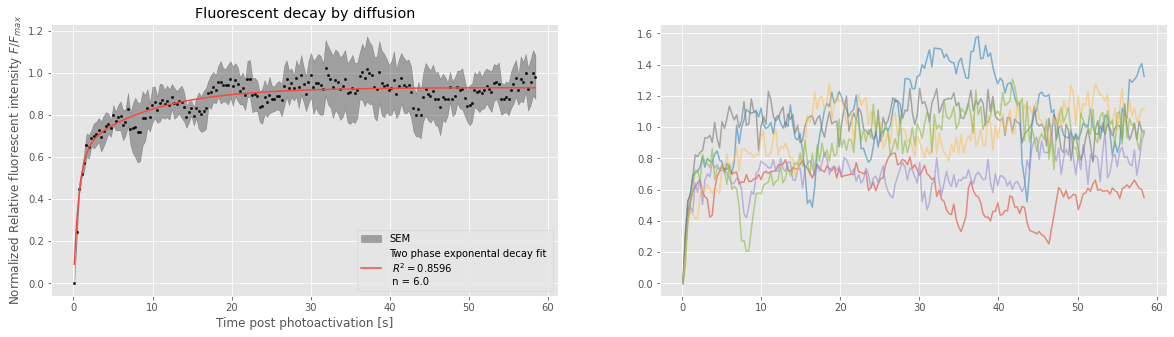

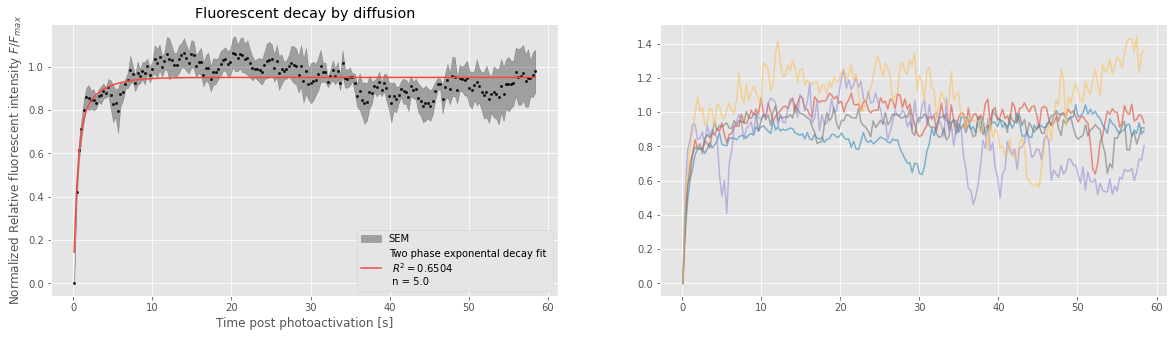

In [7]:
frap = ExperimentGroup('/Volumes/YOMI/data/analyzed_data/diffusivity/',)
frap.add_experiment('Vasa(AA1-164)', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_hypergerm/10hpf', molecular_weight=16.87, disorder=1)
'/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_hypergerm'
frap.add_experiment('Vasa(AA1-164)', 24, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_hypergerm/24hpf', molecular_weight=16.87, disorder=1)



<Figure size 432x288 with 0 Axes>

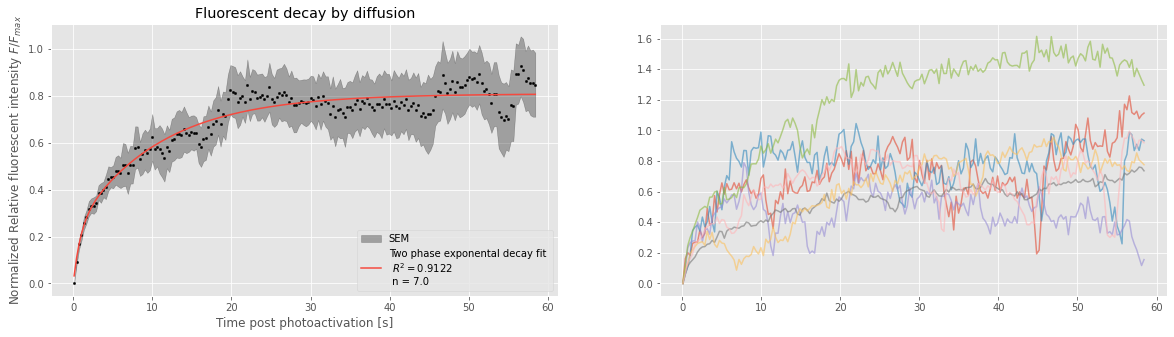

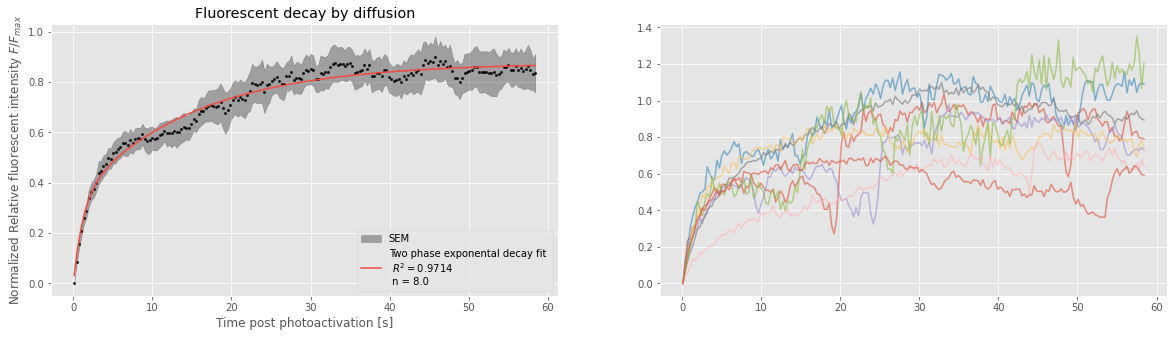

In [8]:
frap.add_experiment('Full length Vasa', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_full_vasa/10hpf', molecular_weight=76.78, disorder=0.4056)
frap.add_experiment('Full length Vasa', 24, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_full_vasa/24hpf', molecular_weight=76.78, disorder=0.4056)


<Figure size 432x288 with 0 Axes>

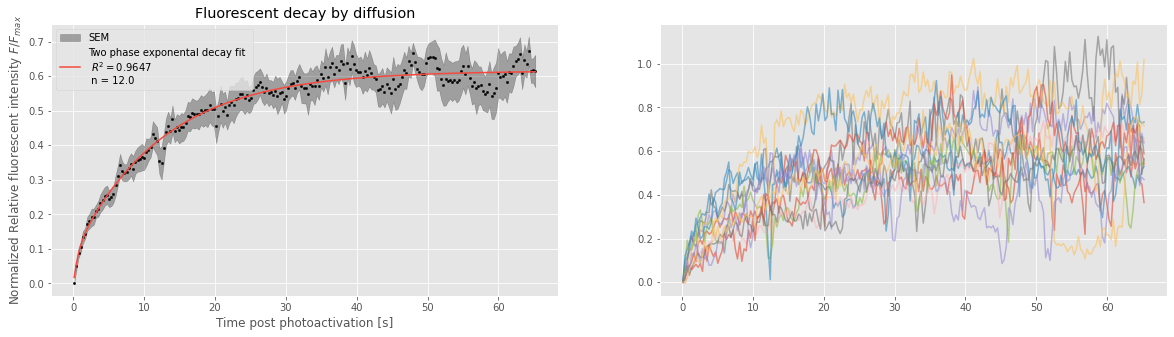

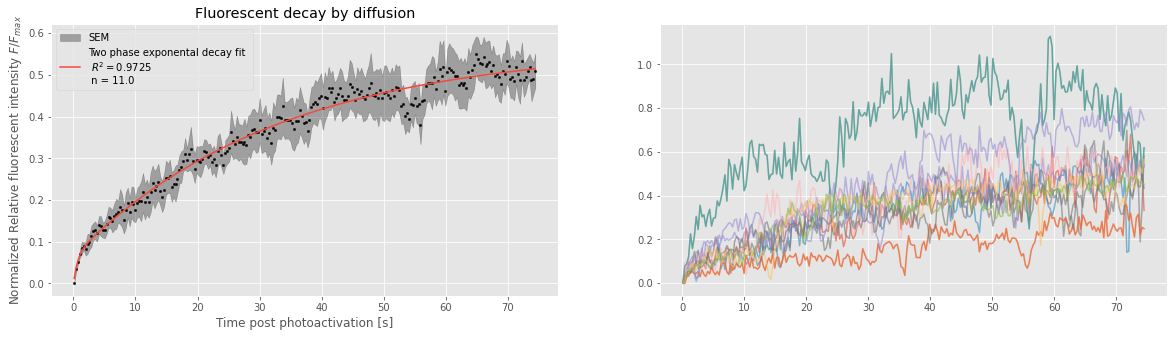

In [9]:
frap.add_experiment('Dead end', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_dnd/10hpf', molecular_weight=46.0, disorder=0.2871)
frap.add_experiment('Dead end', 24, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_dnd/24hpf', molecular_weight=46.0, disorder=0.2871)

<Figure size 432x288 with 0 Axes>

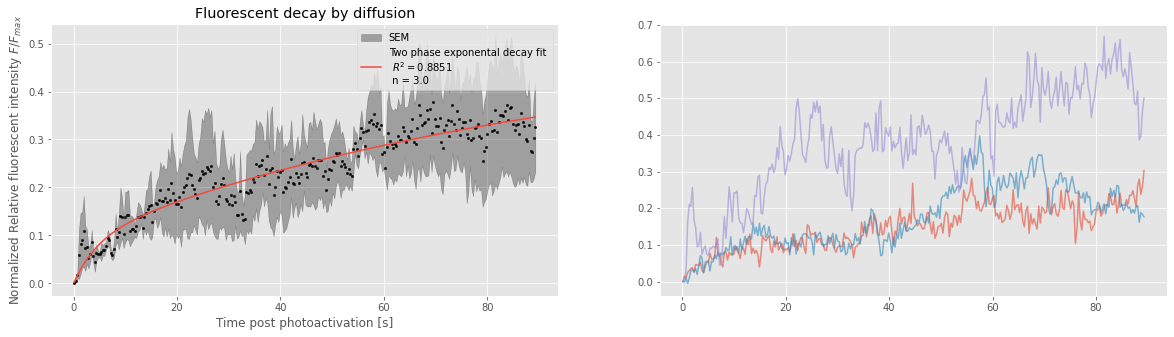

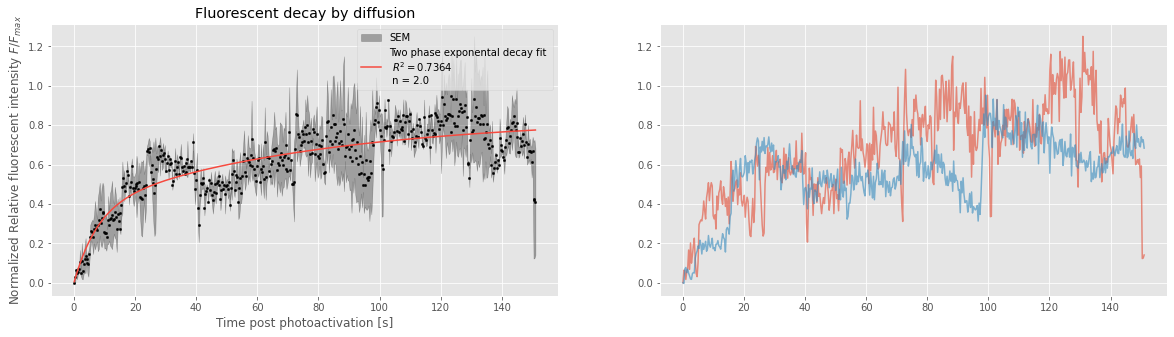

In [10]:
frap.add_experiment('Dazl', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_dazl/10hpf', molecular_weight=25.51, disorder=0.4760)
frap.add_experiment('Dazl F91A', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_mutdazl/10hpf', molecular_weight=25.51, disorder=0.4760)

<Figure size 432x288 with 0 Axes>

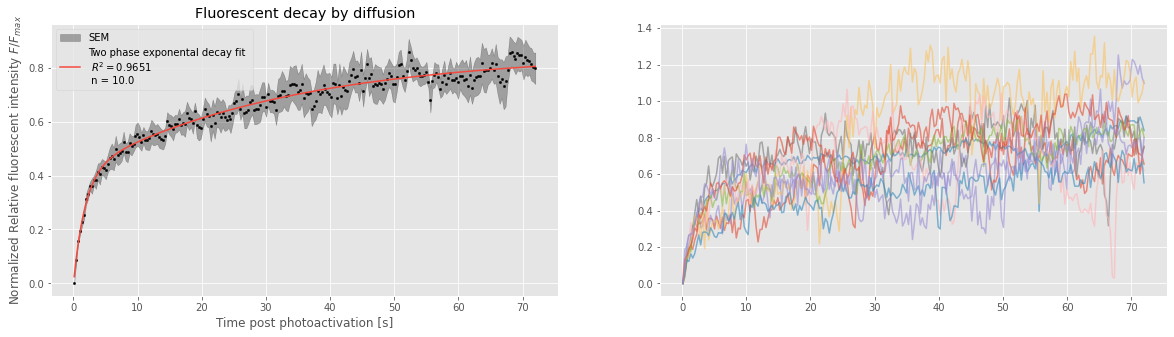

In [11]:
frap.add_experiment('Granulito', 10, '/Volumes/YOMI/data/analyzed_data/diffusivity/FRAP_gra/10hpf', molecular_weight=16.68, disorder=0.2979)

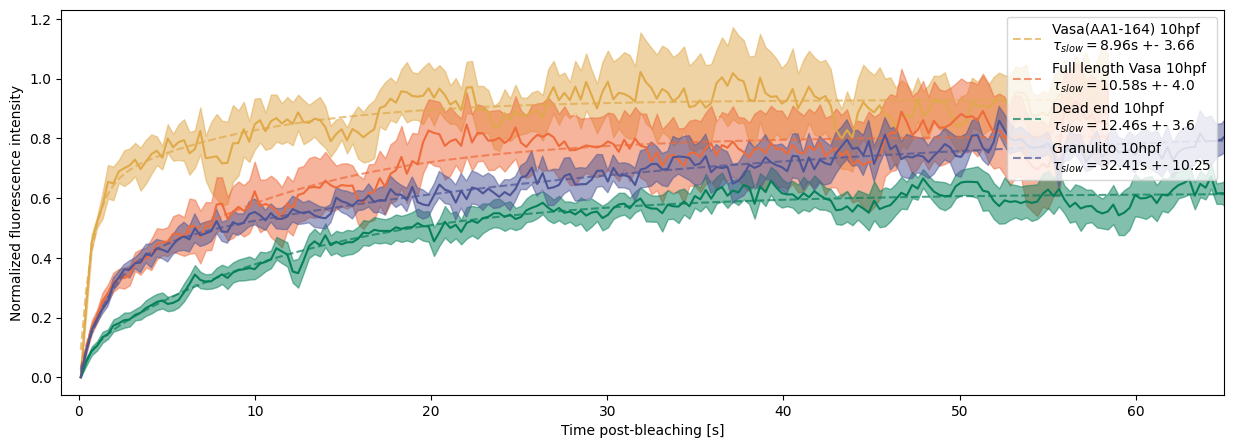

In [12]:
plt.style.use('default')
frap.plot_experiments(
    ['Vasa(AA1-164) 10hpf', 'Full length Vasa 10hpf', 'Dead end 10hpf', 'Granulito 10hpf'],
    developmental_stage=[10],
    plot_all=False,
    save_path='/Users/izbuser/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master/_Raz Lab/_Presentations/PR/20220900_PR_PhD-1/source images/diff_plots',
    plot_fit=True
)

In [13]:
totaltime_post = time.perf_counter()
totaltime = totaltime_post-totaltime_pre
print(totaltime)


194.87531591199996


In [14]:
frap.dict_experiments.keys()

dict_keys(['Vasa(AA1-164) 10hpf', 'Vasa(AA1-164) 24hpf', 'Full length Vasa 10hpf', 'Full length Vasa 24hpf', 'Dead end 10hpf', 'Dead end 24hpf', 'Dazl 10hpf', 'Dazl F91A 10hpf', 'Granulito 10hpf'])

In [15]:
def bar_graphs(names, save_name):
    taus = []
    taus_err = []
    # x = []
    colors = []
    ages = []
    proteins = []
    for name in names:
        xxp = frap.dict_experiments[name][2]
        protein = frap.dict_experiments[name][0]
        tau = xxp.fit_parameters['tau slow']
        hpf = frap.dict_experiments[name][1]
        err = xxp.fit_parameters_sigma['tau slow']/np.sqrt(xxp.sample_count)
        color = frap.get_protein_color(protein, 'early' if hpf < 15 else 'late')
        colors.append (color)
        taus.append(tau)
        proteins.append(protein)
        taus_err.append(err)
        # ages.append(f'{hpf} hpf \n n={int(xxp.sample_count)}')
        ages.append(f'{protein} \n {hpf} hpf')
    xval = [a for a in range(len(names))]
    fig, ax = plt.subplots()
    ax.bar(xval, taus, yerr=taus_err, color=colors, alpha=0.85, tick_label=ages, width=0.75, capsize=3, ecolor='#231F20')
    ax.set_ylabel(r'Difffusivity  ($\tau$ [s])')
    # ax.legend()
    plt.savefig('/Users/izbuser/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master/_Raz Lab/_Presentations/PR/20220900_PR_PhD-1/source images/tau_plots' + os.path.sep + save_name + '.pdf')

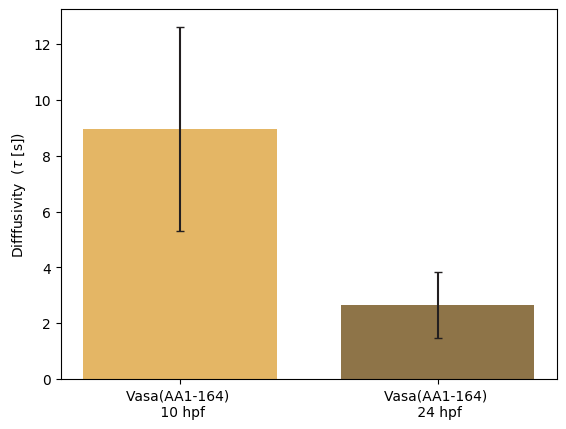

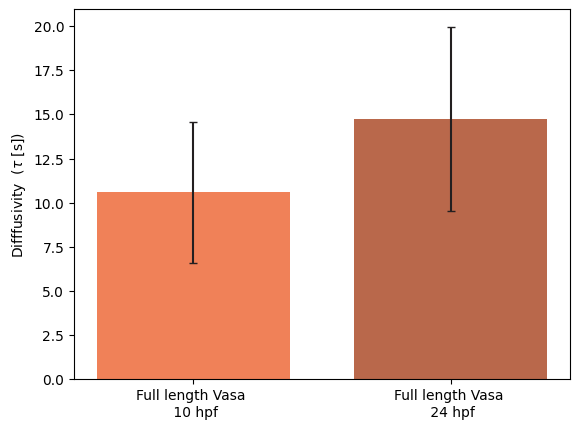

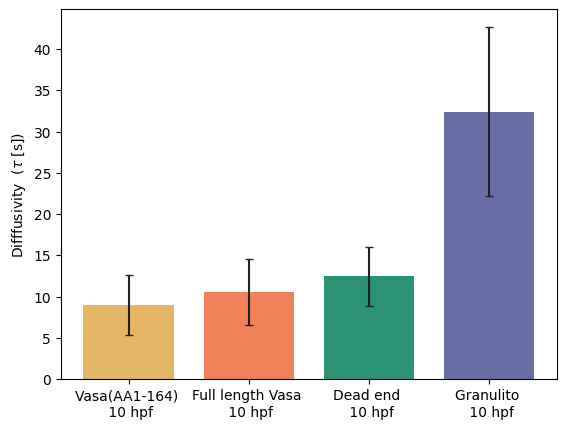

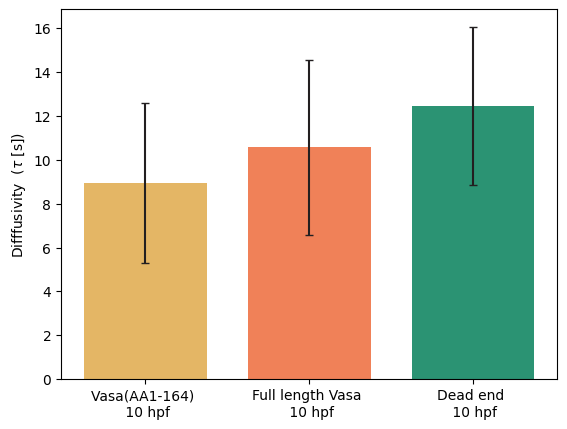

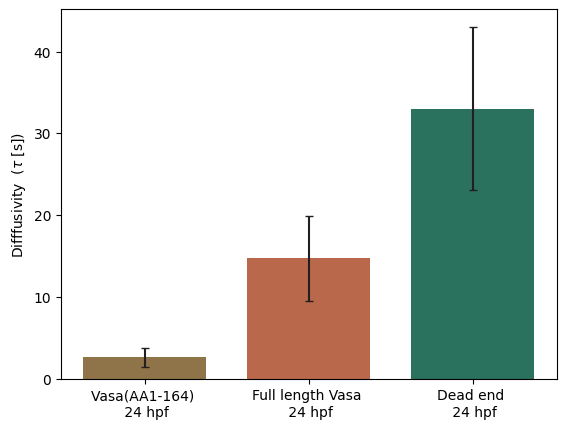

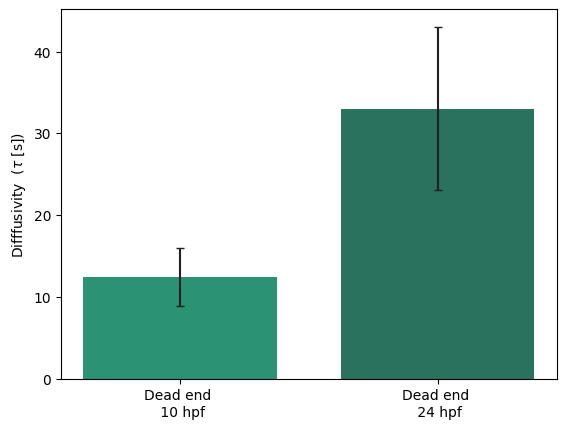

In [16]:
bar_graphs(['Vasa(AA1-164) 10hpf', 'Vasa(AA1-164) 24hpf'], 'hyper1024')
bar_graphs(['Full length Vasa 10hpf', 'Full length Vasa 24hpf'], 'vs10254')
bar_graphs(['Vasa(AA1-164) 10hpf', 'Full length Vasa 10hpf', 'Dead end 10hpf', 'Granulito 10hpf'], 'all')
bar_graphs(['Vasa(AA1-164) 10hpf', 'Full length Vasa 10hpf', 'Dead end 10hpf'], 'early')
bar_graphs(['Vasa(AA1-164) 24hpf', 'Full length Vasa 24hpf', 'Dead end 24hpf'], 'late')
bar_graphs(['Dead end 10hpf', 'Dead end 24hpf'], 'Dnd')

'#AD2F64'

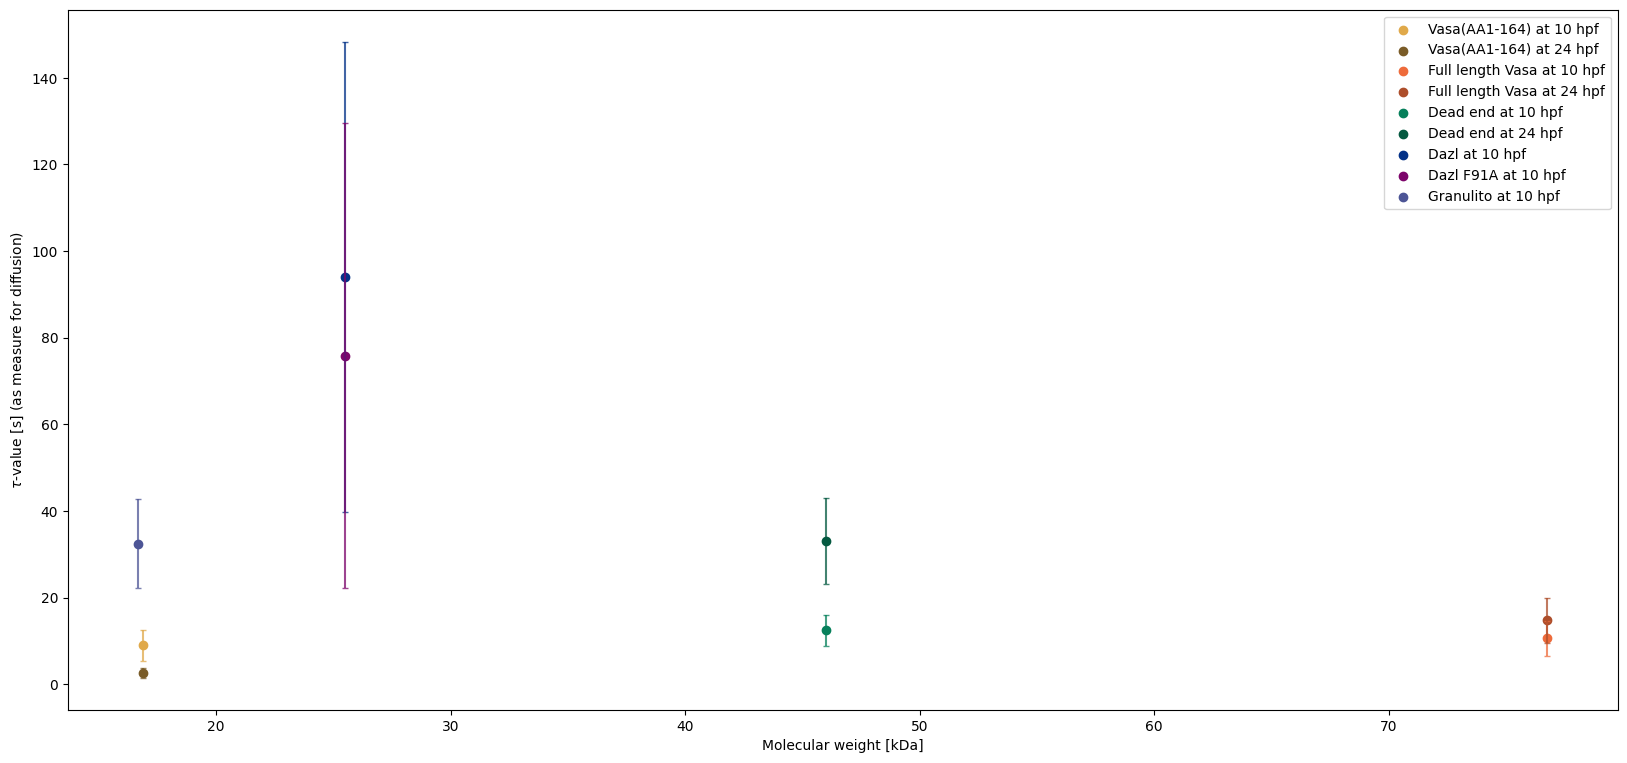

In [17]:
frap.plot_molecular_weight(include_disorder=False, mega_graph=False)
frap.get_protein_color('nanos', 'early')

---
# Testing

In [18]:
name, hpf, xxp = frap.dict_experiments['Vasa(AA1-164) 10hpf']
tau = xxp.fit_parameters['tau slow']
mw = xxp.mw
do = xxp.disorder_percent

print(do)

1


Text(0.5, 0, 'Molecular weight [kDa]')

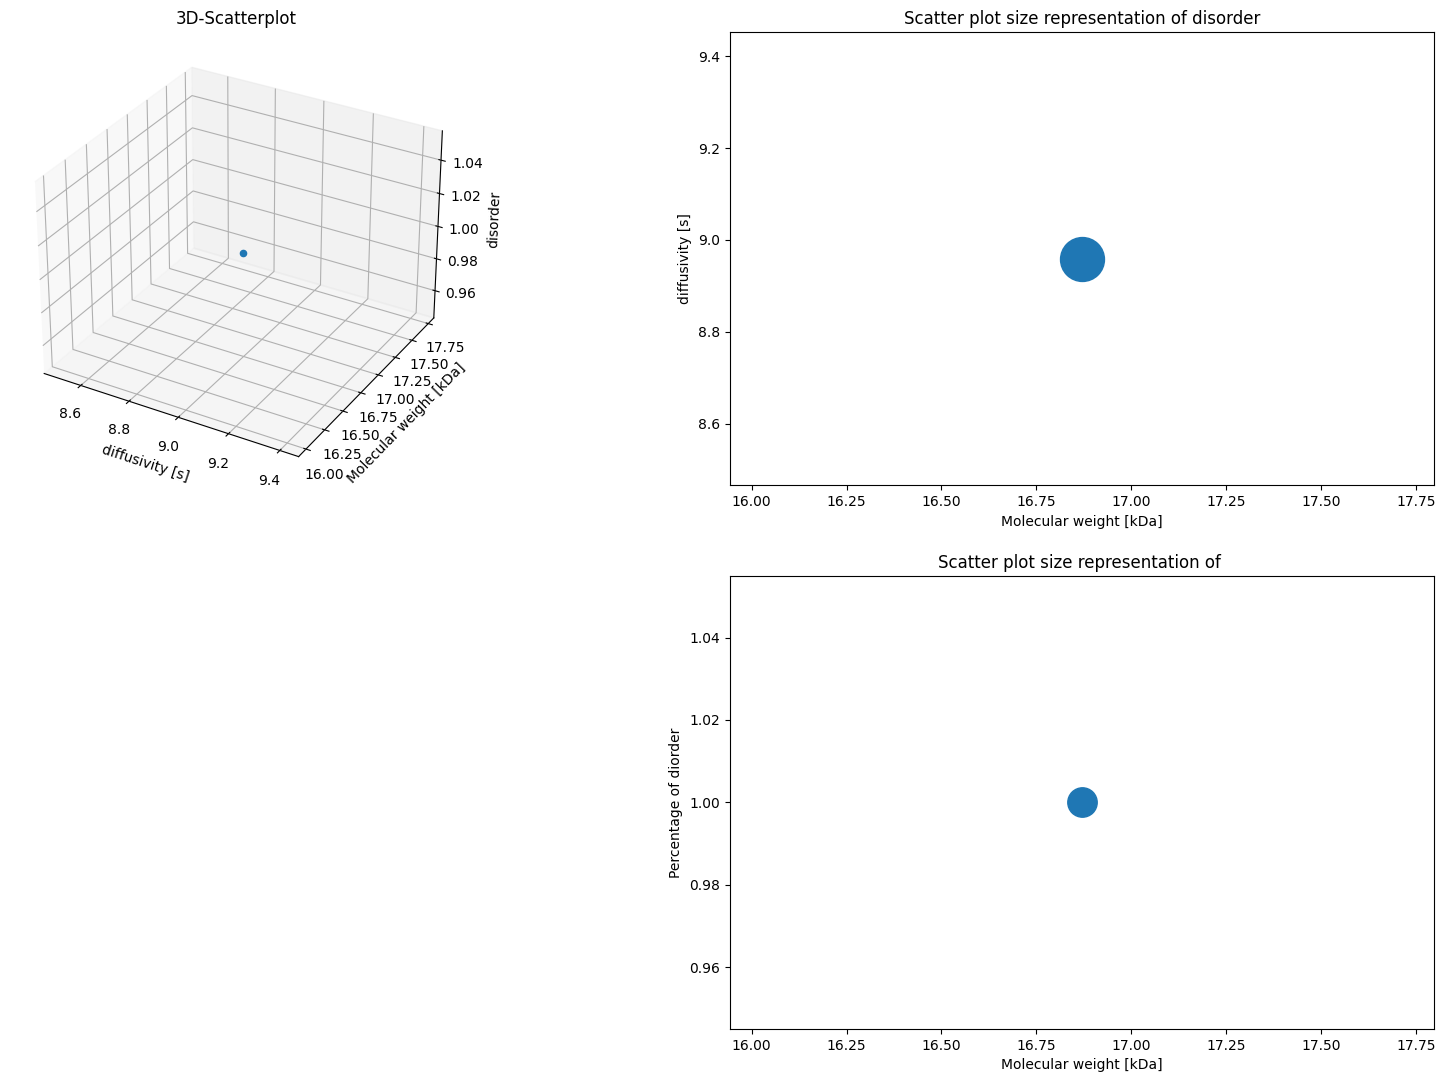

In [19]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(321, projection='3d')
ax1.scatter(tau, mw, do)
ax1.set_title('3D-Scatterplot')
ax1.set_xlabel('diffusivity [s]')
ax1.set_ylabel('Molecular weight [kDa]')
ax1.set_zlabel('disorder')

ax2 = fig.add_subplot(322)
ax2.set_title('Scatter plot size representation of disorder')
ax2.scatter(mw, tau, s=1000*do)
ax2.set_ylabel('diffusivity [s]')
ax2.set_xlabel('Molecular weight [kDa]')

ax3 = fig.add_subplot(324)
ax3.set_title('Scatter plot size representation of ')
ax3.scatter(mw, do, s=50*tau)
ax3.set_ylabel('Percentage of diorder')
ax3.set_xlabel('Molecular weight [kDa]')

In [20]:
# def diff(mw1, mw2):
#     # d = np.sqrt(mw1)/np.sqrt(mw2)
#     d = mw1 + mw2
#     return d

# fig, ax = plt.subplots(figsize=(15,15))

# v=1
# for clr in [violet, blue1, petrol, green, teal, lgreen, orange, dorange, red, purpur, violet2, blue2]:
#     x = []
#     y = []
#     z = []
#     f = []
#     for a in range(10, 150):
#         x.append(a)
#         y.append(diff(a, v))
#     ax.plot(x, y, color=clr[0])
#     for b in range(290, 151, -1):
#         z.append(b)
#         f.append(diff(b, v))
#     ax.plot(z, f, color=clr[3])
#     v+=50
    




In [21]:
xxx = []
yyy = []

for i in range(50):
    xxx.append(i)
    yyy.append(3*i**3+2)

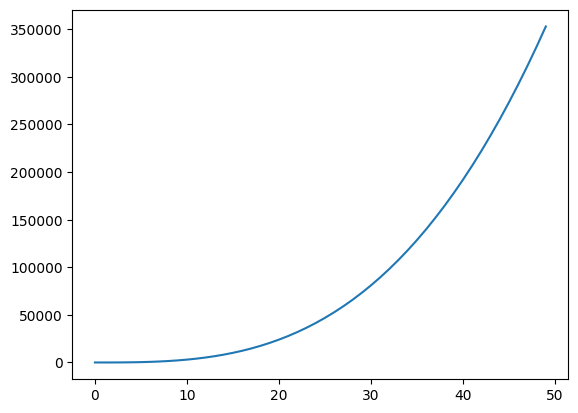

In [22]:
graph = plt.plot(xxx, yyy)

---
current_version: 3.2.2
---
This miserable piece of crap was written by J.Wegner; for any questions adress: jwegner1@uni-muenster.de

#### Version 1.0
Extracts data from Fiji-exported .csv-files and plots the intenstity for one channel that can be selected - is directed towards data from dendra

#### Version 2.1
Version 2 introduces the comparison of columns with each other from multiple sources  
Feature added for extraction of bleach time and timeintervals of acqusition from .lsm-files; requires the input of path from a .lsm-file

#### Version 2.2
Added the 'dataextractor' function allowing for easier change in numbers of datasets that can be fed into software  
Added GUI functionality featureing a menu for easy guided way to select the lsm-path, csv-active, csv-passive and export-path  
Added a way to plot as many analyzed/passive csv's as wished by the user following a plt.style-set colorscheme

#### Version 2.3.0
Added feature: export of a .csv-file containing compact information of the calculared (displayed/plotted) values for each condition  
Added feature: animation for the activated channel; stops after about 4s

#### Version 2.3.1
Bug fix: Animated curve doesn't stop ater 100 frames anymore  
Bug fix: The plot style 'ggdark' was adjusted to better fit dark presentations

#### Version 2.3.2
Bug fix: The tkinter window is now locating to the middle of the screen, but has a fixed heighth and width, which might cause problems

#### Version 2.4 
Bug fix: Title of graph and axes for main intensity plot  
Introduciton of two phase exponential curve fitting and calculation of the diffusion coefficient  
DEV note: The equation for calculating the diffusion coefficient is lacking the exact area information  
DEV note: BATCHimport is work in progress


#### Version 2.4.1
Bug fix: The equation for the diffusion coefficient now has the correct area information  
Introduction of a GUI that displays the parameter of the fit  
Saving the fitting-parameter dictionary as CSV


#### Version 2.4.2
DEV note: Batch-mode is up and running; batch file is copied and fit_parameters is attached


#### Version 2.4.3
DEV note: Normalization according to Phair et al. - requires different input files, adjusted GUI and batch input


#### Version 2.4.4
Bug fix: Prebleach frames are not how they should be - seem kind of shifted. 
Bug fix: Doublchecked and made the bleach start/stop values 


#### Version 2.4.5
FEATURE: Batch file only needs the lsm file and the secondary granule paths, the rest is autocompleted if the common naming scheme is followed

#### Version 3.0
DEV note: Code was rewritten to be more object oriented. One experiment becomes one object of the 'experiment' and all experiments are summarized in a ExperimentGroup object. This leaves room for a GUI and inside the GUI coupling of of experiments (such as ctrl and treatment conditions)  
Feature: Summarizing all experiments is moved from an external jupyter nb to the main code. For the future 'napari' could be implemented to be independent from ImageJ for the analysis   
Feature: Better documentation of what operations have been performed with json and saving also of more detailed information such as lists of x/y values at for various data. Therefore, substituting the batch_results '.csv'-file

#### Version 3.1
DEV note: Transferred to a Jupyter Notebook. Is potenialy worse for a GUI, but better for semi manual processing and testing  
Feature: Introduced a built in comparision to a control (hypergerm), that is imaged in parallel

#### Version 3.1.2
DEV note: Grown independent of batchfiles by introducing another regex based iterator

#### Version 3.2
DEV note: New version supports FRAP but looses capability to do iFRAP. Reason for this is a difference in division (first frame after activation vs. last frame before bleaching)  
BUG: Adjacent granules can not be calulated any more

#### Version 3.2.1
Feature: Now the class "ExperimentGroup" features methods "add_experiment", "plot_multiple" and "plot_experiments". add_experiments activates the iterator and which analyses a given folder. plot_experiments can be called (with or without prompt) it selects the experiments that are given as an argument and passes the information and passes it to plot_multiple, which plots multiple curves
BUG: If a file or a column or file is missing the whole program is crashing. Possible fix: try except loop, which is noted in the json file and printed out in the summary

#### Version 3.2.2
BUG FIX: 
FEATURE: 